In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In this Kaggle competition we need to the predict the value of transaction each customers will carry out given a set of features. 

In [2]:
#Load the training set
train = pd.read_csv('train.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4459 entries, 0 to 4458
Columns: 4993 entries, ID to 9fc776466
dtypes: float64(1845), int64(3147), object(1)
memory usage: 169.9+ MB


In [4]:
#Check for any NaN in the dataframe
train.isnull().values.any()

False

In [5]:
train.head()

,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


The features are anonymized

In [7]:
test = pd.read_csv('test.csv')

Let us look more into the training dataset and look at the mean, S.D and variance of the features.

In [19]:
features_train = train.describe().T

In [20]:
np.sum(features_train['std']<=0)

256

We see that we have at least 256 features that have zero standard deviation which means that they are just a constant term and can be removed from the dataset. But we must also confirm that we have the same number from the test set too

In [21]:
features_test = test.describe().T

In [27]:
np.sum(features_test['std']<=0.0)

0

The std for all the features seems to be non-zero for the test set. We will thus not remove any data as of now

### Plotting the target distribution

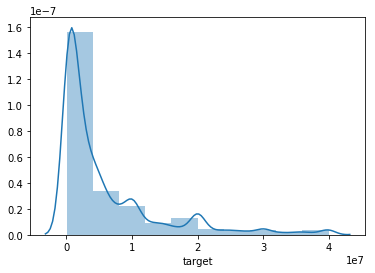

In [31]:
sns.distplot(train['target'], bins = 10)

The target is heavily skewed towards zero. Let us take a logarithm of the target and then take a histogram.

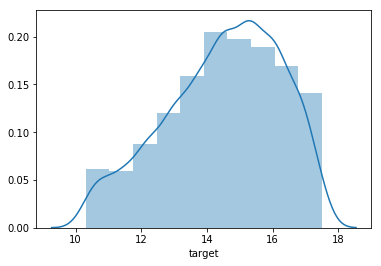

In [32]:
sns.distplot(np.log1p(train['target']), bins = 10)

Because of the presence of several zeroes in the target, it was tranformed using $log\left(1+x\right)$ to avoid null values. It will also be much easier to deal with this transformed target for the purposes of any sort of predictive analysis and modelling. This can be easily reversed using the function $e^x-1$.

In [6]:
X = train.iloc[:, 2:].values
y = np.log1p(train.iloc[:, 1].values)# to make it easier to carry out modeling 

In [7]:
#train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Random Forest Trial

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error

In [20]:
model_rf = RandomForestRegressor(n_estimators= 1000, criterion= 'mse', max_depth= 30,
                              min_samples_split=5, min_samples_leaf= 2,max_features='auto',
                              bootstrap= 'True')

In [21]:
print(model_rf.get_params())

{'bootstrap': 'True', 'criterion': 'mse', 'max_depth': 30, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 1000, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [ ]:
model_rf.fit(X_train, y_train)

In [47]:
y_pred = model_rf.predict(X_test)

In [48]:
print('The Root Mean Log Square Error is: {0:0.6f}'.format(mean_squared_log_error(y_test, y_pred)))

The Root Mean Log Square Error is: 0.01


### XGBoost

In [8]:
import xgboost as xgb
from xgboost import XGBRegressor

In [9]:
xgb_model = XGBRegressor(max_depth = 10, 
                         learning_rate= 0.003, 
                         n_estimators= 3000, 
                         subsample= 0.7, 
                         colsample_bytree= 0.5)

In [10]:
xgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric='rmse', early_stopping_rounds=50, verbose=True)

[0]	validation_0-rmse:14.0667	validation_1-rmse:14.0307
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:14.025	validation_1-rmse:13.989
[2]	validation_0-rmse:13.9836	validation_1-rmse:13.9476
[3]	validation_0-rmse:13.9424	validation_1-rmse:13.9063
[4]	validation_0-rmse:13.9012	validation_1-rmse:13.8651
[5]	validation_0-rmse:13.8602	validation_1-rmse:13.824
[6]	validation_0-rmse:13.8192	validation_1-rmse:13.7832
[7]	validation_0-rmse:13.7784	validation_1-rmse:13.7423
[8]	validation_0-rmse:13.7378	validation_1-rmse:13.7016
[9]	validation_0-rmse:13.6972	validation_1-rmse:13.661
[10]	validation_0-rmse:13.6567	validation_1-rmse:13.6206
[11]	validation_0-rmse:13.6165	validation_1-rmse:13.5803
[12]	validation_0-rmse:13.5763	validation_1-rmse:13.5401
[13]	validation_0-rmse:13.5363	validation_1-rmse:13.5
[14]	validation_0-rmse:13.4963	validation_1-rmse:13.4601
[15

[142]	validation_0-rmse:9.27198	validation_1-rmse:9.2384
[143]	validation_0-rmse:9.2451	validation_1-rmse:9.21137
[144]	validation_0-rmse:9.21825	validation_1-rmse:9.18456
[145]	validation_0-rmse:9.19146	validation_1-rmse:9.1578
[146]	validation_0-rmse:9.16475	validation_1-rmse:9.13114
[147]	validation_0-rmse:9.13821	validation_1-rmse:9.10467
[148]	validation_0-rmse:9.11172	validation_1-rmse:9.07825
[149]	validation_0-rmse:9.08535	validation_1-rmse:9.05184
[150]	validation_0-rmse:9.05898	validation_1-rmse:9.02557
[151]	validation_0-rmse:9.03289	validation_1-rmse:8.99955
[152]	validation_0-rmse:9.00673	validation_1-rmse:8.97348
[153]	validation_0-rmse:8.98058	validation_1-rmse:8.94735
[154]	validation_0-rmse:8.95451	validation_1-rmse:8.92135
[155]	validation_0-rmse:8.92854	validation_1-rmse:8.89546
[156]	validation_0-rmse:8.90265	validation_1-rmse:8.86962
[157]	validation_0-rmse:8.87683	validation_1-rmse:8.84396
[158]	validation_0-rmse:8.85111	validation_1-rmse:8.81823
[159]	validation_

[284]	validation_0-rmse:6.17115	validation_1-rmse:6.14958
[285]	validation_0-rmse:6.15371	validation_1-rmse:6.13224
[286]	validation_0-rmse:6.1364	validation_1-rmse:6.11505
[287]	validation_0-rmse:6.11926	validation_1-rmse:6.09802
[288]	validation_0-rmse:6.10199	validation_1-rmse:6.08094
[289]	validation_0-rmse:6.08492	validation_1-rmse:6.06403
[290]	validation_0-rmse:6.06768	validation_1-rmse:6.04685
[291]	validation_0-rmse:6.05054	validation_1-rmse:6.02997
[292]	validation_0-rmse:6.03357	validation_1-rmse:6.01311
[293]	validation_0-rmse:6.01663	validation_1-rmse:5.99631
[294]	validation_0-rmse:5.99969	validation_1-rmse:5.97959
[295]	validation_0-rmse:5.98287	validation_1-rmse:5.96288
[296]	validation_0-rmse:5.96608	validation_1-rmse:5.94618
[297]	validation_0-rmse:5.94932	validation_1-rmse:5.92955
[298]	validation_0-rmse:5.93266	validation_1-rmse:5.91294
[299]	validation_0-rmse:5.91604	validation_1-rmse:5.89648
[300]	validation_0-rmse:5.89942	validation_1-rmse:5.88002
[301]	validatio

[426]	validation_0-rmse:4.17404	validation_1-rmse:4.17964
[427]	validation_0-rmse:4.16298	validation_1-rmse:4.16884
[428]	validation_0-rmse:4.15179	validation_1-rmse:4.15783
[429]	validation_0-rmse:4.14075	validation_1-rmse:4.14693
[430]	validation_0-rmse:4.12972	validation_1-rmse:4.13614
[431]	validation_0-rmse:4.1188	validation_1-rmse:4.12563
[432]	validation_0-rmse:4.10779	validation_1-rmse:4.11494
[433]	validation_0-rmse:4.09679	validation_1-rmse:4.10419
[434]	validation_0-rmse:4.08588	validation_1-rmse:4.09361
[435]	validation_0-rmse:4.07503	validation_1-rmse:4.08293
[436]	validation_0-rmse:4.0642	validation_1-rmse:4.07222
[437]	validation_0-rmse:4.05337	validation_1-rmse:4.06157
[438]	validation_0-rmse:4.04248	validation_1-rmse:4.051
[439]	validation_0-rmse:4.03173	validation_1-rmse:4.04054
[440]	validation_0-rmse:4.02109	validation_1-rmse:4.03011
[441]	validation_0-rmse:4.0104	validation_1-rmse:4.01978
[442]	validation_0-rmse:3.99976	validation_1-rmse:4.00934
[443]	validation_0-

[568]	validation_0-rmse:2.9012	validation_1-rmse:2.95279
[569]	validation_0-rmse:2.89412	validation_1-rmse:2.94617
[570]	validation_0-rmse:2.887	validation_1-rmse:2.93948
[571]	validation_0-rmse:2.88002	validation_1-rmse:2.93286
[572]	validation_0-rmse:2.87313	validation_1-rmse:2.92634
[573]	validation_0-rmse:2.86618	validation_1-rmse:2.91979
[574]	validation_0-rmse:2.8592	validation_1-rmse:2.91308
[575]	validation_0-rmse:2.85233	validation_1-rmse:2.90664
[576]	validation_0-rmse:2.84545	validation_1-rmse:2.90015
[577]	validation_0-rmse:2.83865	validation_1-rmse:2.89366
[578]	validation_0-rmse:2.83185	validation_1-rmse:2.88726
[579]	validation_0-rmse:2.82508	validation_1-rmse:2.88093
[580]	validation_0-rmse:2.81827	validation_1-rmse:2.87449
[581]	validation_0-rmse:2.81162	validation_1-rmse:2.86817
[582]	validation_0-rmse:2.80483	validation_1-rmse:2.8618
[583]	validation_0-rmse:2.79828	validation_1-rmse:2.85575
[584]	validation_0-rmse:2.79157	validation_1-rmse:2.84948
[585]	validation_0-

[710]	validation_0-rmse:2.10801	validation_1-rmse:2.22413
[711]	validation_0-rmse:2.10361	validation_1-rmse:2.2203
[712]	validation_0-rmse:2.09933	validation_1-rmse:2.21645
[713]	validation_0-rmse:2.09498	validation_1-rmse:2.2126
[714]	validation_0-rmse:2.09062	validation_1-rmse:2.2087
[715]	validation_0-rmse:2.08641	validation_1-rmse:2.20495
[716]	validation_0-rmse:2.08222	validation_1-rmse:2.20116
[717]	validation_0-rmse:2.07804	validation_1-rmse:2.19746
[718]	validation_0-rmse:2.0737	validation_1-rmse:2.19371
[719]	validation_0-rmse:2.06949	validation_1-rmse:2.19001
[720]	validation_0-rmse:2.06525	validation_1-rmse:2.18633
[721]	validation_0-rmse:2.06113	validation_1-rmse:2.18266
[722]	validation_0-rmse:2.05704	validation_1-rmse:2.17908
[723]	validation_0-rmse:2.05284	validation_1-rmse:2.17547
[724]	validation_0-rmse:2.04865	validation_1-rmse:2.17178
[725]	validation_0-rmse:2.04449	validation_1-rmse:2.16819
[726]	validation_0-rmse:2.04037	validation_1-rmse:2.1646
[727]	validation_0-

[852]	validation_0-rmse:1.62823	validation_1-rmse:1.82152
[853]	validation_0-rmse:1.62555	validation_1-rmse:1.81942
[854]	validation_0-rmse:1.623	validation_1-rmse:1.81745
[855]	validation_0-rmse:1.62042	validation_1-rmse:1.81547
[856]	validation_0-rmse:1.618	validation_1-rmse:1.81354
[857]	validation_0-rmse:1.61537	validation_1-rmse:1.81155
[858]	validation_0-rmse:1.61279	validation_1-rmse:1.80958
[859]	validation_0-rmse:1.61034	validation_1-rmse:1.80768
[860]	validation_0-rmse:1.60789	validation_1-rmse:1.80584
[861]	validation_0-rmse:1.60553	validation_1-rmse:1.80397
[862]	validation_0-rmse:1.60312	validation_1-rmse:1.80209
[863]	validation_0-rmse:1.60059	validation_1-rmse:1.80017
[864]	validation_0-rmse:1.59805	validation_1-rmse:1.7982
[865]	validation_0-rmse:1.59557	validation_1-rmse:1.79633
[866]	validation_0-rmse:1.59318	validation_1-rmse:1.79444
[867]	validation_0-rmse:1.59082	validation_1-rmse:1.79253
[868]	validation_0-rmse:1.58848	validation_1-rmse:1.79072
[869]	validation_0-

[994]	validation_0-rmse:1.34945	validation_1-rmse:1.6177
[995]	validation_0-rmse:1.34794	validation_1-rmse:1.61672
[996]	validation_0-rmse:1.34638	validation_1-rmse:1.61581
[997]	validation_0-rmse:1.34489	validation_1-rmse:1.61476
[998]	validation_0-rmse:1.34337	validation_1-rmse:1.6138
[999]	validation_0-rmse:1.342	validation_1-rmse:1.61291
[1000]	validation_0-rmse:1.34063	validation_1-rmse:1.61199
[1001]	validation_0-rmse:1.33926	validation_1-rmse:1.61112
[1002]	validation_0-rmse:1.33782	validation_1-rmse:1.61016
[1003]	validation_0-rmse:1.33647	validation_1-rmse:1.60926
[1004]	validation_0-rmse:1.33503	validation_1-rmse:1.60825
[1005]	validation_0-rmse:1.33356	validation_1-rmse:1.60733
[1006]	validation_0-rmse:1.33214	validation_1-rmse:1.60641
[1007]	validation_0-rmse:1.33085	validation_1-rmse:1.60549
[1008]	validation_0-rmse:1.32951	validation_1-rmse:1.60459
[1009]	validation_0-rmse:1.32797	validation_1-rmse:1.60354
[1010]	validation_0-rmse:1.32654	validation_1-rmse:1.60262
[1011]	

[1134]	validation_0-rmse:1.19268	validation_1-rmse:1.52168
[1135]	validation_0-rmse:1.19176	validation_1-rmse:1.5211
[1136]	validation_0-rmse:1.19093	validation_1-rmse:1.52061
[1137]	validation_0-rmse:1.1902	validation_1-rmse:1.52018
[1138]	validation_0-rmse:1.18937	validation_1-rmse:1.51969
[1139]	validation_0-rmse:1.18859	validation_1-rmse:1.5193
[1140]	validation_0-rmse:1.18787	validation_1-rmse:1.51888
[1141]	validation_0-rmse:1.18713	validation_1-rmse:1.51843
[1142]	validation_0-rmse:1.18627	validation_1-rmse:1.518
[1143]	validation_0-rmse:1.18536	validation_1-rmse:1.5176
[1144]	validation_0-rmse:1.18461	validation_1-rmse:1.51719
[1145]	validation_0-rmse:1.18387	validation_1-rmse:1.5168
[1146]	validation_0-rmse:1.18299	validation_1-rmse:1.51641
[1147]	validation_0-rmse:1.18226	validation_1-rmse:1.51603
[1148]	validation_0-rmse:1.18129	validation_1-rmse:1.5156
[1149]	validation_0-rmse:1.18041	validation_1-rmse:1.51513
[1150]	validation_0-rmse:1.17965	validation_1-rmse:1.51474
[1151

[1274]	validation_0-rmse:1.10087	validation_1-rmse:1.47699
[1275]	validation_0-rmse:1.10037	validation_1-rmse:1.47672
[1276]	validation_0-rmse:1.09977	validation_1-rmse:1.4765
[1277]	validation_0-rmse:1.0994	validation_1-rmse:1.47632
[1278]	validation_0-rmse:1.09903	validation_1-rmse:1.47615
[1279]	validation_0-rmse:1.09857	validation_1-rmse:1.47593
[1280]	validation_0-rmse:1.09811	validation_1-rmse:1.47573
[1281]	validation_0-rmse:1.09746	validation_1-rmse:1.47551
[1282]	validation_0-rmse:1.09705	validation_1-rmse:1.47536
[1283]	validation_0-rmse:1.09654	validation_1-rmse:1.47513
[1284]	validation_0-rmse:1.09591	validation_1-rmse:1.47501
[1285]	validation_0-rmse:1.09515	validation_1-rmse:1.4748
[1286]	validation_0-rmse:1.09467	validation_1-rmse:1.47459
[1287]	validation_0-rmse:1.09415	validation_1-rmse:1.47435
[1288]	validation_0-rmse:1.09361	validation_1-rmse:1.47412
[1289]	validation_0-rmse:1.09317	validation_1-rmse:1.4739
[1290]	validation_0-rmse:1.09277	validation_1-rmse:1.47374
[

[1414]	validation_0-rmse:1.04429	validation_1-rmse:1.45664
[1415]	validation_0-rmse:1.04389	validation_1-rmse:1.45653
[1416]	validation_0-rmse:1.04363	validation_1-rmse:1.45644
[1417]	validation_0-rmse:1.04332	validation_1-rmse:1.45637
[1418]	validation_0-rmse:1.04302	validation_1-rmse:1.4563
[1419]	validation_0-rmse:1.04272	validation_1-rmse:1.45617
[1420]	validation_0-rmse:1.0424	validation_1-rmse:1.45611
[1421]	validation_0-rmse:1.04199	validation_1-rmse:1.45599
[1422]	validation_0-rmse:1.04176	validation_1-rmse:1.45592
[1423]	validation_0-rmse:1.0415	validation_1-rmse:1.45582
[1424]	validation_0-rmse:1.0412	validation_1-rmse:1.45575
[1425]	validation_0-rmse:1.04094	validation_1-rmse:1.45565
[1426]	validation_0-rmse:1.04066	validation_1-rmse:1.45555
[1427]	validation_0-rmse:1.04024	validation_1-rmse:1.45538
[1428]	validation_0-rmse:1.04	validation_1-rmse:1.45531
[1429]	validation_0-rmse:1.03957	validation_1-rmse:1.45521
[1430]	validation_0-rmse:1.03931	validation_1-rmse:1.45513
[143

[1554]	validation_0-rmse:1.0066	validation_1-rmse:1.44688
[1555]	validation_0-rmse:1.00641	validation_1-rmse:1.44685
[1556]	validation_0-rmse:1.00623	validation_1-rmse:1.44679
[1557]	validation_0-rmse:1.00591	validation_1-rmse:1.4467
[1558]	validation_0-rmse:1.00575	validation_1-rmse:1.44669
[1559]	validation_0-rmse:1.00553	validation_1-rmse:1.44664
[1560]	validation_0-rmse:1.00519	validation_1-rmse:1.44653
[1561]	validation_0-rmse:1.0049	validation_1-rmse:1.44651
[1562]	validation_0-rmse:1.0047	validation_1-rmse:1.44644
[1563]	validation_0-rmse:1.00446	validation_1-rmse:1.44641
[1564]	validation_0-rmse:1.00404	validation_1-rmse:1.44635
[1565]	validation_0-rmse:1.0039	validation_1-rmse:1.44634
[1566]	validation_0-rmse:1.00367	validation_1-rmse:1.44632
[1567]	validation_0-rmse:1.0034	validation_1-rmse:1.4463
[1568]	validation_0-rmse:1.00312	validation_1-rmse:1.44627
[1569]	validation_0-rmse:1.00299	validation_1-rmse:1.44627
[1570]	validation_0-rmse:1.00284	validation_1-rmse:1.44622
[157

[1692]	validation_0-rmse:0.976538	validation_1-rmse:1.44193
[1693]	validation_0-rmse:0.976363	validation_1-rmse:1.44191
[1694]	validation_0-rmse:0.976281	validation_1-rmse:1.44192
[1695]	validation_0-rmse:0.976169	validation_1-rmse:1.44193
[1696]	validation_0-rmse:0.976028	validation_1-rmse:1.44186
[1697]	validation_0-rmse:0.975754	validation_1-rmse:1.44182
[1698]	validation_0-rmse:0.975628	validation_1-rmse:1.44182
[1699]	validation_0-rmse:0.975531	validation_1-rmse:1.44183
[1700]	validation_0-rmse:0.975433	validation_1-rmse:1.44183
[1701]	validation_0-rmse:0.975345	validation_1-rmse:1.44185
[1702]	validation_0-rmse:0.97503	validation_1-rmse:1.44183
[1703]	validation_0-rmse:0.9748	validation_1-rmse:1.44176
[1704]	validation_0-rmse:0.974611	validation_1-rmse:1.44172
[1705]	validation_0-rmse:0.974494	validation_1-rmse:1.44169
[1706]	validation_0-rmse:0.974361	validation_1-rmse:1.44164
[1707]	validation_0-rmse:0.974225	validation_1-rmse:1.44163
[1708]	validation_0-rmse:0.974106	validatio

[1830]	validation_0-rmse:0.954742	validation_1-rmse:1.43946
[1831]	validation_0-rmse:0.954651	validation_1-rmse:1.43947
[1832]	validation_0-rmse:0.954488	validation_1-rmse:1.43947
[1833]	validation_0-rmse:0.9544	validation_1-rmse:1.43951
[1834]	validation_0-rmse:0.954295	validation_1-rmse:1.43949
[1835]	validation_0-rmse:0.954133	validation_1-rmse:1.43948
[1836]	validation_0-rmse:0.95405	validation_1-rmse:1.43948
[1837]	validation_0-rmse:0.953952	validation_1-rmse:1.43947
[1838]	validation_0-rmse:0.953875	validation_1-rmse:1.43949
[1839]	validation_0-rmse:0.95375	validation_1-rmse:1.43949
[1840]	validation_0-rmse:0.95368	validation_1-rmse:1.43948
[1841]	validation_0-rmse:0.953598	validation_1-rmse:1.43948
[1842]	validation_0-rmse:0.953497	validation_1-rmse:1.43949
[1843]	validation_0-rmse:0.95317	validation_1-rmse:1.43941
[1844]	validation_0-rmse:0.95309	validation_1-rmse:1.43938
[1845]	validation_0-rmse:0.952902	validation_1-rmse:1.43934
[1846]	validation_0-rmse:0.952714	validation_1-

[1968]	validation_0-rmse:0.935643	validation_1-rmse:1.43759
[1969]	validation_0-rmse:0.935338	validation_1-rmse:1.43748
[1970]	validation_0-rmse:0.935248	validation_1-rmse:1.43747
[1971]	validation_0-rmse:0.935131	validation_1-rmse:1.43749
[1972]	validation_0-rmse:0.935068	validation_1-rmse:1.43747
[1973]	validation_0-rmse:0.935029	validation_1-rmse:1.43748
[1974]	validation_0-rmse:0.934862	validation_1-rmse:1.43745
[1975]	validation_0-rmse:0.934792	validation_1-rmse:1.43746
[1976]	validation_0-rmse:0.934728	validation_1-rmse:1.43745
[1977]	validation_0-rmse:0.934644	validation_1-rmse:1.43746
[1978]	validation_0-rmse:0.934589	validation_1-rmse:1.43746
[1979]	validation_0-rmse:0.934513	validation_1-rmse:1.43749
[1980]	validation_0-rmse:0.934357	validation_1-rmse:1.43745
[1981]	validation_0-rmse:0.934302	validation_1-rmse:1.43747
[1982]	validation_0-rmse:0.934193	validation_1-rmse:1.43746
[1983]	validation_0-rmse:0.933995	validation_1-rmse:1.43742
[1984]	validation_0-rmse:0.933948	valida

[2105]	validation_0-rmse:0.917041	validation_1-rmse:1.43568
[2106]	validation_0-rmse:0.916933	validation_1-rmse:1.43571
[2107]	validation_0-rmse:0.916694	validation_1-rmse:1.4357
[2108]	validation_0-rmse:0.916377	validation_1-rmse:1.43566
[2109]	validation_0-rmse:0.916268	validation_1-rmse:1.43564
[2110]	validation_0-rmse:0.916212	validation_1-rmse:1.43562
[2111]	validation_0-rmse:0.916117	validation_1-rmse:1.4356
[2112]	validation_0-rmse:0.916027	validation_1-rmse:1.43561
[2113]	validation_0-rmse:0.91593	validation_1-rmse:1.43561
[2114]	validation_0-rmse:0.915472	validation_1-rmse:1.43558
[2115]	validation_0-rmse:0.915421	validation_1-rmse:1.43559
[2116]	validation_0-rmse:0.915352	validation_1-rmse:1.43561
[2117]	validation_0-rmse:0.915283	validation_1-rmse:1.43561
[2118]	validation_0-rmse:0.91519	validation_1-rmse:1.43562
[2119]	validation_0-rmse:0.915128	validation_1-rmse:1.43563
[2120]	validation_0-rmse:0.915037	validation_1-rmse:1.43567
[2121]	validation_0-rmse:0.914907	validation

[2243]	validation_0-rmse:0.901215	validation_1-rmse:1.43465
[2244]	validation_0-rmse:0.901166	validation_1-rmse:1.43467
[2245]	validation_0-rmse:0.901051	validation_1-rmse:1.43468
[2246]	validation_0-rmse:0.900983	validation_1-rmse:1.43468
[2247]	validation_0-rmse:0.900913	validation_1-rmse:1.43467
[2248]	validation_0-rmse:0.900837	validation_1-rmse:1.43465
[2249]	validation_0-rmse:0.900604	validation_1-rmse:1.43463
[2250]	validation_0-rmse:0.900553	validation_1-rmse:1.43464
[2251]	validation_0-rmse:0.900498	validation_1-rmse:1.43464
[2252]	validation_0-rmse:0.900451	validation_1-rmse:1.43466
[2253]	validation_0-rmse:0.900389	validation_1-rmse:1.43469
[2254]	validation_0-rmse:0.900159	validation_1-rmse:1.43472
[2255]	validation_0-rmse:0.900111	validation_1-rmse:1.43471
[2256]	validation_0-rmse:0.900025	validation_1-rmse:1.43469
[2257]	validation_0-rmse:0.899945	validation_1-rmse:1.43466
[2258]	validation_0-rmse:0.899678	validation_1-rmse:1.43461
[2259]	validation_0-rmse:0.899546	valida

[2380]	validation_0-rmse:0.887917	validation_1-rmse:1.43383
[2381]	validation_0-rmse:0.887701	validation_1-rmse:1.43377
[2382]	validation_0-rmse:0.887556	validation_1-rmse:1.43376
[2383]	validation_0-rmse:0.887502	validation_1-rmse:1.43378
[2384]	validation_0-rmse:0.887335	validation_1-rmse:1.43378
[2385]	validation_0-rmse:0.887296	validation_1-rmse:1.43379
[2386]	validation_0-rmse:0.887221	validation_1-rmse:1.43379
[2387]	validation_0-rmse:0.887115	validation_1-rmse:1.43379
[2388]	validation_0-rmse:0.887065	validation_1-rmse:1.43377
[2389]	validation_0-rmse:0.887017	validation_1-rmse:1.43378
[2390]	validation_0-rmse:0.886961	validation_1-rmse:1.43379
[2391]	validation_0-rmse:0.886909	validation_1-rmse:1.43381
[2392]	validation_0-rmse:0.886739	validation_1-rmse:1.43382
[2393]	validation_0-rmse:0.886688	validation_1-rmse:1.43381
[2394]	validation_0-rmse:0.886619	validation_1-rmse:1.43381
[2395]	validation_0-rmse:0.886543	validation_1-rmse:1.43383
[2396]	validation_0-rmse:0.886495	valida

[2517]	validation_0-rmse:0.874803	validation_1-rmse:1.43305
[2518]	validation_0-rmse:0.874662	validation_1-rmse:1.43302
[2519]	validation_0-rmse:0.874603	validation_1-rmse:1.43302
[2520]	validation_0-rmse:0.874493	validation_1-rmse:1.433
[2521]	validation_0-rmse:0.874418	validation_1-rmse:1.43302
[2522]	validation_0-rmse:0.874365	validation_1-rmse:1.43303
[2523]	validation_0-rmse:0.874277	validation_1-rmse:1.43303
[2524]	validation_0-rmse:0.874233	validation_1-rmse:1.43303
[2525]	validation_0-rmse:0.874191	validation_1-rmse:1.43303
[2526]	validation_0-rmse:0.873814	validation_1-rmse:1.43295
[2527]	validation_0-rmse:0.873748	validation_1-rmse:1.43295
[2528]	validation_0-rmse:0.8737	validation_1-rmse:1.43294
[2529]	validation_0-rmse:0.873656	validation_1-rmse:1.43296
[2530]	validation_0-rmse:0.873622	validation_1-rmse:1.43297
[2531]	validation_0-rmse:0.873555	validation_1-rmse:1.43296
[2532]	validation_0-rmse:0.873409	validation_1-rmse:1.43295
[2533]	validation_0-rmse:0.873237	validation

[2655]	validation_0-rmse:0.862372	validation_1-rmse:1.43254
[2656]	validation_0-rmse:0.86214	validation_1-rmse:1.43247
[2657]	validation_0-rmse:0.862102	validation_1-rmse:1.43247
[2658]	validation_0-rmse:0.862044	validation_1-rmse:1.43246
[2659]	validation_0-rmse:0.861969	validation_1-rmse:1.43247
[2660]	validation_0-rmse:0.86191	validation_1-rmse:1.43244
[2661]	validation_0-rmse:0.86186	validation_1-rmse:1.43245
[2662]	validation_0-rmse:0.861809	validation_1-rmse:1.43244
[2663]	validation_0-rmse:0.861761	validation_1-rmse:1.43245
[2664]	validation_0-rmse:0.861712	validation_1-rmse:1.43246
[2665]	validation_0-rmse:0.861537	validation_1-rmse:1.43243
[2666]	validation_0-rmse:0.861497	validation_1-rmse:1.43242
[2667]	validation_0-rmse:0.86144	validation_1-rmse:1.4324
[2668]	validation_0-rmse:0.861345	validation_1-rmse:1.4324
[2669]	validation_0-rmse:0.861304	validation_1-rmse:1.43241
[2670]	validation_0-rmse:0.861186	validation_1-rmse:1.43243
[2671]	validation_0-rmse:0.861143	validation_1

[2793]	validation_0-rmse:0.848548	validation_1-rmse:1.43125
[2794]	validation_0-rmse:0.848457	validation_1-rmse:1.43127
[2795]	validation_0-rmse:0.848289	validation_1-rmse:1.43123
[2796]	validation_0-rmse:0.84809	validation_1-rmse:1.43121
[2797]	validation_0-rmse:0.848032	validation_1-rmse:1.43121
[2798]	validation_0-rmse:0.84787	validation_1-rmse:1.43114
[2799]	validation_0-rmse:0.847809	validation_1-rmse:1.43115
[2800]	validation_0-rmse:0.84763	validation_1-rmse:1.43114
[2801]	validation_0-rmse:0.847446	validation_1-rmse:1.43112
[2802]	validation_0-rmse:0.847293	validation_1-rmse:1.4311
[2803]	validation_0-rmse:0.847258	validation_1-rmse:1.43111
[2804]	validation_0-rmse:0.847186	validation_1-rmse:1.43111
[2805]	validation_0-rmse:0.847097	validation_1-rmse:1.43111
[2806]	validation_0-rmse:0.847066	validation_1-rmse:1.43112
[2807]	validation_0-rmse:0.847027	validation_1-rmse:1.43113
[2808]	validation_0-rmse:0.846996	validation_1-rmse:1.43114
[2809]	validation_0-rmse:0.846884	validation

[2931]	validation_0-rmse:0.83604	validation_1-rmse:1.43033
[2932]	validation_0-rmse:0.835998	validation_1-rmse:1.4303
[2933]	validation_0-rmse:0.835964	validation_1-rmse:1.43029
[2934]	validation_0-rmse:0.835889	validation_1-rmse:1.43028
[2935]	validation_0-rmse:0.835816	validation_1-rmse:1.43029
[2936]	validation_0-rmse:0.835615	validation_1-rmse:1.43025
[2937]	validation_0-rmse:0.835415	validation_1-rmse:1.43021
[2938]	validation_0-rmse:0.835352	validation_1-rmse:1.43019
[2939]	validation_0-rmse:0.83526	validation_1-rmse:1.43022
[2940]	validation_0-rmse:0.835226	validation_1-rmse:1.43022
[2941]	validation_0-rmse:0.835191	validation_1-rmse:1.43023
[2942]	validation_0-rmse:0.835109	validation_1-rmse:1.43024
[2943]	validation_0-rmse:0.83503	validation_1-rmse:1.43023
[2944]	validation_0-rmse:0.834913	validation_1-rmse:1.43027
[2945]	validation_0-rmse:0.834745	validation_1-rmse:1.43026
[2946]	validation_0-rmse:0.834709	validation_1-rmse:1.43025
[2947]	validation_0-rmse:0.834674	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.003,
       max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
       n_estimators=3000, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.7)

In [16]:
y_pred = xgb_model.predict(X_test)

In [18]:
print('The Root Mean Log Square Error is: {0:0.6f}'.format(mean_squared_log_error(y_test, y_pred)))

The Root Mean Log Square Error is: 0.009297
